In [18]:
import numpy as np
import seaborn as sns
import pylab as plt
%matplotlib inline

# Monte Carlo
Gives you a ballpark figure of the expectation of some distritbution using samples. 


## Example: Estimating Pi with Monte Carlo
Example is drawn from a lecture by Ian Murray: http://videolectures.net/mlss09uk_murray_mcmc/

We use an indicator function to ask "Are you inside this *unit* circle?" The indicator function looks like: $I(x^2+y^2 < 1)$

The example is only working with a quarter of the unit circle (first quadrant), so we multiply by 4.

The estimation function works like this: Draw $N$ samples for $x$ and $y$ and put them into a $Nx2$ matrix. Then we compute the indicator function for each row or sample in the matrix. After that we take the expectation or mean of the result. We can see that with only 10 samples, we can get pretty close to the true value. It should be noted that we'll never get the true value, and if that's necessary Monte Carlo methods are not the right choice.

"This is a really stupid way to estimate pi"

In [19]:
def estimate_pi(num_samples=10):
    dimensions = 2
    samples = np.random.rand(num_samples, dimensions)
    pi = 4*np.mean(np.sum(np.multiply(samples,samples),1)<1)
    return pi

In [20]:
num_samples = 10
pi = estimate_pi(num_samples)
pi

4.0

In [21]:
num_samples = 100000000
pi = estimate_pi(num_samples)
pi

3.1415114399999999

# Markov Chains

Under what circumstances will a Markov Chain converge to a desired distribution? A Markov Chain simply consists of a set of random variables $\textbf{z}^{(\tau)}$ The probability of a state given the previous state is conditionally independent of all previous states $P(\textbf{z}^{(\tau)}|\textbf{z}^{(\tau-1)})$

Markov Chains are specified by giving a probability of the initial state $\textbf{z}^0$ and transition probabilities for $P(\textbf{z}^{(\tau)}|\textbf{z}^{(\tau-1)})$

#### You can ignore the code below, its not used for anything

In [22]:
class MarkovChain:
    def __init__(self, num_states, T=None, pi=None):
        self.num_states = num_states 
        self.state_sequence = np.zeros(2)
        if T == None:
            self.T = generate_matrix(num_states)
        else:
            self.T = T
        if pi == None:
            self.pi = generate_vector(num_states)
        else:
            self.pi = pi

In [23]:
def generate_matrix(n):
    ## Return a nxn uniformly random row stochastic matrix
    matrix = np.random.rand(n,n)
    for i in range(n):
        matrix[i,:] = matrix[i,:]/np.sum(matrix[i,:])
    return matrix

def generate_vector(n):
    ## Return a n element uniform stochastic vector
    vector = np.random.rand(n) 
    vector = vector/np.sum(vector) #Normalize
    return vector

# Markov Chain Monte Carlo
Markov Chain Monte Carlo (MCMC) attempts to sample from a posterior distribution. MCMC works particularly well on high-dimensional spaces and on a large class of distributions.

We sample from a simple proposal distribution (simple enough to draw samples from). We also maintain a record of the current state $\textbf{z}^\tau$. The next sample depends on the current state, $q(\textbf{z}|\textbf{z}^{(\tau)})$. So the sequence of samples form a Markov Chain.

At each cycle of the algorithm, generate a *candidate sample* from the proposal distribution. Accept or reject the sample using some criterion. There are several flavors or algorithms for MCMC, the simplest being the Metropolis algorithm. 
## Metropolis Hastings


This algorithm is synonymous with MCMC as it is typically the first algorithm used to demonstrate MCMC. 

We want to sample our proposals from some distribution $Q \sim \mathcal{N(x,\sigma^2)}$ 

We choose our proposal distribution to be a Gaussian because its convenient to sample from. We use the mean $x$ to say that our sample mean is the state *we are in now* with some noise $\sigma^2$.

### Example: Step Size Demo
Notes and code taken directly from Ian Murrays lecture: http://videolectures.net/mlss09uk_murray_mcmc/


Explore a space $\mathcal{N}(0,1)$ with step sizes $\sigma$

In [24]:
#Demo code from Ian Murrays lecture (rewritten in numpy/python)
def testing(x):
    return -0.5*x*x

def dumb_metropolis(init, log_ptilde, iters, sigma):
    '''
    log_ptilde: function handle saying this is my log probability function up to a constant
    '''
    D = init.size # Not used
    samples = np.zeros(iters)
    state = init
    Lp_state = log_ptilde(state)
    rand = np.random.randn()
    accepts = 0
    for ss in range(iters):
        #Propose
        # Draw from a normal distribution with our mean as the current state and some noise sigma
        prop = state + sigma*np.random.randn(state.size)
        Lp_prop = log_ptilde(prop)
        if np.log(np.random.randn()) < (Lp_prop - Lp_state):
            #Accept
            state = prop
            Lp_state = Lp_prop
            accepts += 1
        samples[ss] = state
    return samples, accepts

In [25]:
init = np.asarray(0)

Propose new states with step size 100. This isn't very probable under a unit Gaussian, so almost all proposals are rejected and we remain in the current state for a very long time. By a very small chance, we draw a small value and our proposal is accepted, we perturb where we are and stay there for a very long time. It is hard to argue that we have 1000 samples to work with when we almost never move. 

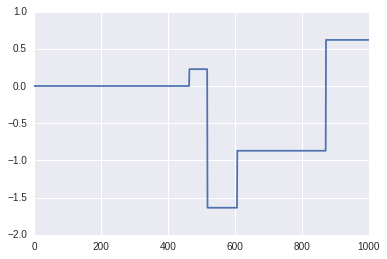

0.4% accepts


In [26]:
sigma = 100
samples, acceptance = dumb_metropolis(init, testing, 1000, sigma)
plt.plot(samples)
plt.show()
acceptance = acceptance/1000
print(str(acceptance*100) + "% accepts")

Here we use $\sigma = 1$ so we have the width of our proposal similar to the width of our distribution. 

(10000,)


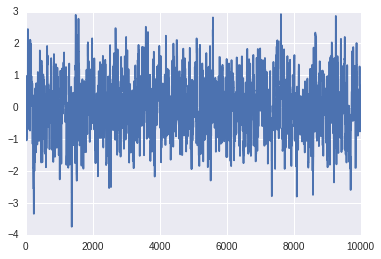

26.36% accepts


In [27]:
sigma = 1
samples, acceptance = dumb_metropolis(init,testing,10000, sigma)
print(samples.shape)
plt.plot(samples)
plt.show()
acceptance = acceptance/10000
print(str(acceptance*100) + "% accepts")

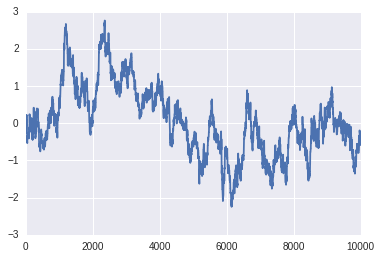

34.69% accepts


In [28]:
sigma = 0.1
samples, acceptance = dumb_metropolis(init, testing, 10000, sigma)
plt.plot(samples)
plt.show()
acceptance = acceptance/10000
print(str(acceptance*100) + "% accepts")

Too much acceptance is bad because the rejection is the only thing that tells us about the distribution we want to explore. Elsewise, if all moves are accepted then we are just taking a random walk, proposed by Q, and has no relation our problem. The accept/reject stage provides a bit of information and it is the only input to the algorithm about the distribution you're interested in. So the optimal acceptance rate is not 100%. You're aiming for "about a half" due to the concept of information gain. However it is a little less than a half because the information you're being given is not independent (due to Markovianity). 

# Sequential Monte Carlo (Particle Filters)

Notes from: Udacity course Computer Vision https://www.udacity.com/course/viewer#!/c-ud810/l-3353778638/m-3345078563

The basic idea is to represent a density by a set of samples or particles rather than represent it analytically. The particles can have a weight attached to them. 

In [29]:
def f(xt, t):
    return 0.5*xt + 25*xt/(1+np.square(xt)) + 8*np.cos(1.2*t)

def h(xt):
    return np.square(xt)/20

In [39]:
T = 100
q0 = 0.1
r0 = 1
iters = 3000
qinit = 1
rinit = 0.1
num_particles = 500

In [40]:
def generate_data(T, q, r):
    '''
    T: Final time step (length of time)
    '''
    x = np.zeros(T)
    y = np.zeros(T)
    for t in range(T):
        if t < (T-1):
            x[t+1] = f(x[t],t) + np.sqrt(q)*np.random.randn(1)
        y[t] = h(x[t]) + np.sqrt(r)*np.random.randn(1)
    return x, y, q, r

In [ ]:
def resampling():
    pass

In [ ]:
T = y.size[0]
q = np.zeros(iters)
r = np.zeros(iters)
X = np.zeros((iters, T))
loglik = np.zeros(iters)
q[0] = qinit
r[0] = rinit
#Particle filter
x_pf = np.zeros(num_particles,T)
a_pf = np.zeros(num_particles,T) #ancestor indices
w_pf = np.zeros(num_particles,T) #weights
loglik = 0
for t in range(T):
    if t != 0:
        ind = resampling(w[:,t-1])